In [1]:
import sys
import os
import matplotlib.pyplot as plt
import cv2

import numpy as np

# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.data_processing.dataset_loader import CoastData
from src.data_processing.dataset_preprocessor import DatasetPreprocessor
from src.data_processing.patchify import Patchify
from src.data_processing.patch_reconstructor import PatchReconstructor

# BiLSTM

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_bilstm_cadiz/"))

data = {}
filtered_data = {}

station = "cadiz"

data[station] = CoastData(data_path, name=station)
filtered_data[station] = data[station].get_images_and_masks()
filtered_data[station] = data[station].split_data()

print("Train images:", len(filtered_data[station]['train']['images']))

path_img = filtered_data[station]['train']['images'][0]
print("Image path:", path_img)
path_mask = filtered_data[station]['train']['masks'][0]

orig_img = cv2.imread(path_img)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)

print("Image shape:", orig_img.shape)
print("Mask shape:", mask.shape)
print()

CoastData: cadiz - 946 images
Coast: cadiz, Total size: 946
Train images: 662
Image path: c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_bilstm_cadiz\images\1625291879.Sat.Jul.03_06_57_59.CET.2021.cadiz.image.jpg
Image shape: (669, 801, 3)
Mask shape: (669, 801)



In [3]:
CLASS_COLORS = {
    'NoData': (0, 0, 0),        # (black)
    'Landwards': (139, 69, 19), # (brown)
    'Seawards': (0, 0, 255),    # (blue)
    'Shoreline': (0, 255, 0)    # (green)
}

# Define a custom colormap for the mask
def apply_custom_colormap_binary(mask):
    # Create an RGB image initialized to black
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Assign colors based on class values
    colored_mask[mask == 0] = CLASS_COLORS["Seawards"]
    colored_mask[mask == 1] = CLASS_COLORS["Landwards"]

    return colored_mask

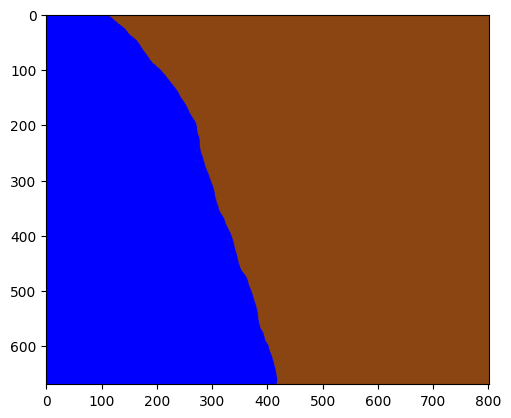

In [4]:
mask_colored = apply_custom_colormap_binary(mask)

plt.imshow(mask_colored)

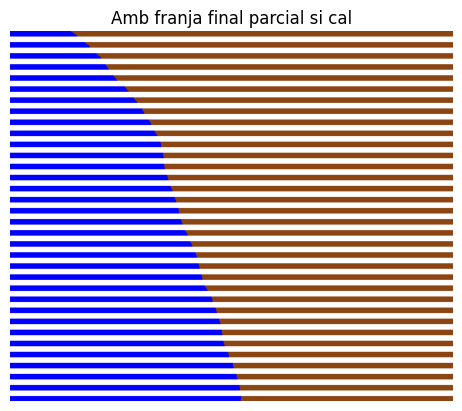

In [5]:
rows, cols = mask_colored.shape[:2]
new_mask = np.full_like(mask_colored, fill_value=255, dtype=np.uint8)

band_size = 10
current_row = 0
i = 0

while True:
    start_src = i * 2 * band_size
    end_src = start_src + band_size

    if start_src >= rows:
        break  # End of the loop

    # If the end_src exceeds the number of rows, adjust it
    if end_src > rows:
        end_src = rows

    remaining_rows = end_src - start_src
    if current_row + remaining_rows > rows:
        remaining_rows = rows - current_row  # Evitar sortir del límit

    new_mask[current_row:current_row + remaining_rows] = mask_colored[start_src:start_src + remaining_rows]

    current_row += 2 * band_size
    i += 1

plt.imshow(new_mask)
plt.axis("off")
plt.title("Amb franja final parcial si cal")
plt.show()

# CNN

In [6]:
# Define a custom colormap for the mask
def apply_custom_colormap(mask):
    # Create an RGB image initialized to black
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Assign colors based on class values
    colored_mask[mask == 0] = CLASS_COLORS["NoData"]
    colored_mask[mask == 2] = CLASS_COLORS["Seawards"]
    colored_mask[mask == 1] = CLASS_COLORS["Landwards"]
    colored_mask[mask == 3] = CLASS_COLORS["Shoreline"]

    return colored_mask

In [7]:
data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

# Load the data, all the different stations
data = CoastData(data_path, name="cadiz") # arenaldentem

filtered_data = data.get_images_and_masks() 

filtered_data = data.split_data()

# Get the first image and mask
image = filtered_data['train']['images'][0]
print("Image path:", image)
mask = filtered_data['train']['masks'][0]

mask_img = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
colored_mask = apply_custom_colormap(mask_img)

print("Path:", image)

CoastData: cadiz - 946 images
Coast: cadiz, Total size: 946
Image path: c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_4_classes\images\1625291879.Sat.Jul.03_06_57_59.CET.2021.cadiz.image.jpg
Path: c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_4_classes\images\1625291879.Sat.Jul.03_06_57_59.CET.2021.cadiz.image.jpg


In [8]:
patchify = Patchify(patch_size=256, stride=128)

result = patchify.extract_patches(image, mask, skip_background=False, skip_no_shoreline=False)
patches = result['patches']

Rows: 4


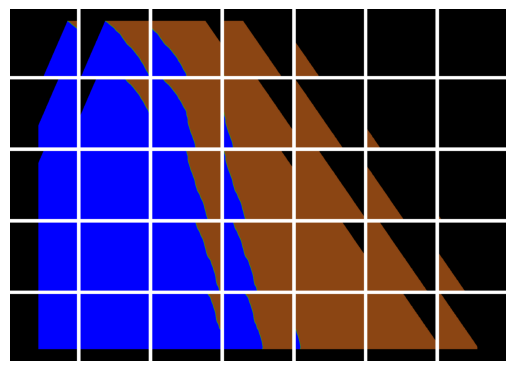

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
import numpy as np
import cv2

rows = max(patch['row'] for patch in patches)
cols = max(patch['col'] for patch in patches)
print("Rows:", rows)

fig, axes = plt.subplots(rows + 1, cols + 1, figsize=(3*(cols + 1), 3 * (rows + 1)))
axes = axes.flatten()

for i, patch in enumerate(patches):
    ax = axes[patch['row'] * (cols + 1) + patch['col']]
    patch['image'] = cv2.cvtColor(patch['image'], cv2.COLOR_BGR2RGB)
    aux_mask = patch['mask']
    aux_mask = apply_custom_colormap(aux_mask)
    ax.imshow(aux_mask)
    ax.axis('off')

plt.tight_layout()
# plt.show()

canvas = FigureCanvas(fig)
canvas.draw()
img = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
img = img.reshape(canvas.get_width_height()[::-1] + (4,))
img = img[:, :, :3]

patchify_mask = np.array(img, dtype=np.uint8)
patchify_mask = patchify_mask[20:-20, 20:-20]

plt.close(fig)

plt.imshow(patchify_mask)
plt.axis("off")
plt.show()


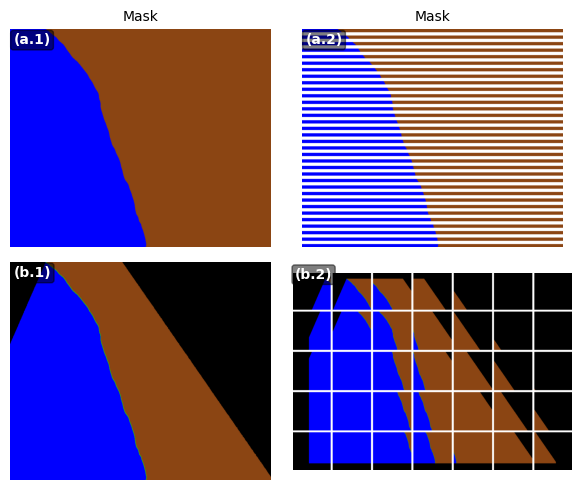

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12/2, 5))  # Slightly wider

axes[0][0].imshow(mask_colored)
axes[0][0].set_title("Mask", fontsize=10)
axes[0][0].axis("off")
axes[0, 0].text(10, 45, "(a.1)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

axes[0][1].set_title("Mask", fontsize=10)
axes[0][1].axis("off")
axes[0][1].imshow(new_mask, cmap="gray")
axes[0, 1].text(10, 45, "(a.2)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# ------------------------------

axes[1][0].imshow(colored_mask)
axes[1][0].axis("off")
axes[1, 0].text(10, 45, "(b.1)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

axes[1][1].axis("off")
axes[1][1].imshow(patchify_mask, cmap="gray")
axes[1, 1].text(10, 45, "(b.2)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.show()

new_mask shape: (669, 801, 3)


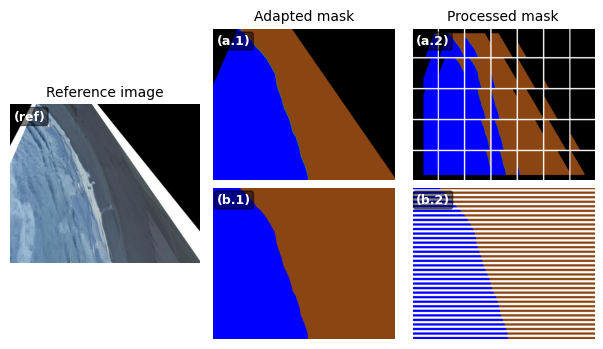

In [48]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 3.2))
gs = GridSpec(2, 3, figure=fig)

ax_big = fig.add_subplot(gs[:, 0])
ax_big.imshow(orig_img)
ax_big.set_title("Reference image", fontsize=10)
ax_big.text(15, 65, "(ref)", fontsize=9, color='white', weight='bold',
            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
ax_big.axis("off")

ax00 = fig.add_subplot(gs[0, 1])
ax00.imshow(colored_mask)
ax00.set_title("Adapted mask", fontsize=10)
ax00.text(15, 70, "(a.1)", fontsize=9, color='white', weight='bold',
          bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
ax00.axis("off")

ax01 = fig.add_subplot(gs[0, 2])
patchify_mask_resized = cv2.resize(patchify_mask, (new_mask.shape[1], new_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
ax01.imshow(patchify_mask_resized, cmap="gray")
ax01.set_title("Processed mask", fontsize=10)
print("new_mask shape:", new_mask.shape)
ax01.text(15, 70, "(a.2)", fontsize=9, color='white', weight='bold',
          bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
ax01.axis("off")

ax10 = fig.add_subplot(gs[1, 1])
ax10.imshow(mask_colored)
# ax10.set_title("Processed B", fontsize=9)
ax10.text(15, 70, "(b.1)", fontsize=9, color='white', weight='bold',
          bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
ax10.axis("off")

ax11 = fig.add_subplot(gs[1, 2])
ax11.imshow(new_mask, cmap="gray")
# ax11.set_title("Patchified B", fontsize=9)
ax11.text(15, 70, "(b.2)", fontsize=9, color='white', weight='bold',
          bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
ax11.axis("off")

plt.subplots_adjust(left=0.01, right=0.99, top=0.98, bottom=0.01, wspace=0.05, hspace=0.05)

fig.savefig(os.path.join("img", "pre_procesing_procedure.png"), bbox_inches='tight', dpi=300)

plt.show()